# Процесс термической обработки стали

**Цель исследования** — провести анализ процесса обработки стали, построить модель машинного обучения и предсказать температуру стали.

**Исходные данные**

Исходные данные извлекаются из файлов:
- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Исследование делится на четыре этапа:
  1. Составление плана работы и исследование данных
  2. Уточнение задачи
  3. Предобработка данных и разработка модели
  4. Составление отчета

## Этап 1. Составление плана работы и исследование данных

### Work plan

1. Расчет параметров технологического процесса:
- Длительность времени между первым и последним замером температуры
- Суммарное время нагрева электродами
- Количество запусков нагрева электродами
- Среднее соотношение потребления активной и реактивной мощности
- Дполнительные параметры при обработке стали (min, max, avg, median)
2. Статистический анализ и предобработка данных
- Визуализация исходных данных
- Определение зависимостей между атрибутами
- Выявление наиболее значимых атрибутов влияющих на целевой признак
- Удаление части атрибутов для сокращения времени обработки данных  
3. Построение моделей машинного обучения
- Выбор нескольких алгоритмов для текущей задачи исследования 
- Определение оптимальных гипер-параметров моделей
- Оптимизация моделей для достижения метрики качества MAE<6
- Сравнение и выбор модели с наименьшим значением ошибки
4. Применяемые подходы для решения задачи регрессии
- Базовые модели (RandomForest, SVM, GradientBoosting, XGBRegressor) 
- Дополнительные модели (TheilSen, Lasso, BaggingRegressor, AdaBoostRegressor)
- Формирование pipeline/ ensemble из нескольких моделей с лучшими метриками
- Применение DummyRegressor для проверки моделей на адекватность 

### Data overview

In [196]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

from functools import reduce
from itertools import combinations
from IPython.display import Image
from IPython.core.display import HTML   

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold, GridSearchCV, cross_validate
from sklearn.feature_selection import RFE
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from lightgbm.sklearn import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import TheilSenRegressor
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.linear_model import SGDRegressor
#from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor

In [2]:
# set global parameters
sns.set(style='darkgrid') 
pd.set_option('precision', 2)
warnings.filterwarnings('ignore')

In [3]:
# define path to directories
path1 = '/datasets/final_steel/'
path2 = 'C:/YandexPracticumProjects/Project_15_PhaseDiagram_ML/'

#### Electrode performance

In [4]:
# read data on electrode performance (generated power, W)
try:
    arc_df = pd.read_csv(path1 + '/data_arc.csv')
except:  
    arc_df = pd.read_csv(path2 + '/data_arc.csv')

In [5]:
# info on electrode performance
arc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
# rename columns 
arc_df = arc_df.rename(columns={
    'Начало нагрева дугой': 'Start of arc heating', 
    'Конец нагрева дугой': 'End of arc heating',
    'Активная мощность': 'Active power',
    'Реактивная мощность': 'Reactive power'
})

In [7]:
# print out 10 rows
arc_df.loc[0:9].style

,key,Start of arc heating,End of arc heating,Active power,Reactive power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.98,0.69
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.81,0.52
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.74,0.50
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.66,1.06
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.69,0.41
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.44,0.28
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.30,0.89
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.49,0.31
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.83,0.52
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.06,0.67


#### Bulk doping materials (volume)

In [8]:
# read data on bulk doping materials (volume, m3)
try:
    bulk_df = pd.read_csv(path1 + '/data_bulk.csv')
except:  
    bulk_df = pd.read_csv(path2 + '/data_bulk.csv')

In [9]:
# info on bulk doping materials (volume)
bulk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [10]:
# print out 10 rows
bulk_df.loc[0:9].style

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,nan,nan,nan,43.00,nan,nan,nan,nan,nan,nan,nan,206.00,nan,150.00,154.00
1,2,nan,nan,nan,73.00,nan,nan,nan,nan,nan,nan,nan,206.00,nan,149.00,154.00
2,3,nan,nan,nan,34.00,nan,nan,nan,nan,nan,nan,nan,205.00,nan,152.00,153.00
3,4,nan,nan,nan,81.00,nan,nan,nan,nan,nan,nan,nan,207.00,nan,153.00,154.00
4,5,nan,nan,nan,78.00,nan,nan,nan,nan,nan,nan,nan,203.00,nan,151.00,152.00
5,6,nan,nan,nan,117.00,nan,nan,nan,nan,nan,nan,nan,204.00,nan,201.00,154.00
6,7,nan,nan,nan,117.00,nan,nan,nan,nan,nan,nan,nan,204.00,nan,152.00,154.00
7,8,nan,nan,nan,99.00,nan,nan,nan,nan,nan,nan,nan,410.00,nan,252.00,153.00
8,9,nan,nan,nan,117.00,nan,nan,nan,nan,nan,nan,nan,107.00,nan,99.00,203.00
9,10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,203.00,nan,102.00,204.00


#### Bulk doping materials (time)

In [11]:
# read data on bulk doping materials (time, sec) 
try:
    bulk_time_df = pd.read_csv(path1 + '/data_bulk_time.csv')
except:  
    bulk_time_df = pd.read_csv(path2 + '/data_bulk_time.csv')

In [12]:
# info on bulk doping materials (time)
bulk_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [13]:
# print out 10 rows
bulk_time_df.loc[0:9].style

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,nan,nan,nan,2019-05-03 11:21:30,nan,nan,nan,nan,nan,nan,nan,2019-05-03 11:03:52,nan,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,nan,nan,nan,2019-05-03 11:46:38,nan,nan,nan,nan,nan,nan,nan,2019-05-03 11:40:20,nan,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,nan,nan,nan,2019-05-03 12:31:06,nan,nan,nan,nan,nan,nan,nan,2019-05-03 12:09:40,nan,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,nan,nan,nan,2019-05-03 12:48:43,nan,nan,nan,nan,nan,nan,nan,2019-05-03 12:41:24,nan,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,nan,nan,nan,2019-05-03 13:18:50,nan,nan,nan,nan,nan,nan,nan,2019-05-03 13:12:56,nan,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,nan,nan,nan,2019-05-03 13:59:24,nan,nan,nan,nan,nan,nan,nan,2019-05-03 13:53:27,nan,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,nan,nan,nan,2019-05-03 14:29:14,nan,nan,nan,nan,nan,nan,nan,2019-05-03 14:22:19,nan,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,nan,nan,nan,2019-05-03 15:04:05,nan,nan,nan,nan,nan,nan,nan,2019-05-03 14:55:46,nan,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,nan,nan,nan,2019-05-03 15:47:34,nan,nan,nan,nan,nan,nan,nan,2019-05-03 15:41:00,nan,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2019-05-03 16:18:52,nan,2019-05-03 16:18:52,2019-05-03 16:18:52


#### Purging gas (flowrate)

In [14]:
# read data on gas purge of steel (flowrate, m3/sec)
try:
    gas_df = pd.read_csv(path1 + '/data_gas.csv')
except:  
    gas_df = pd.read_csv(path2 + '/data_gas.csv')

In [15]:
# info on gas purge of steel (flowrate)
gas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [16]:
# rename column 
gas_df = gas_df.rename(columns={'Газ 1': 'Gas'})

In [17]:
# print out 10 rows
gas_df.loc[0:9].style

,key,Gas
0,1,29.75
1,2,12.56
2,3,28.55
3,4,18.84
4,5,5.41
5,6,11.27
6,7,9.84
7,8,15.17
8,9,8.22
9,10,6.53


#### Temperature measured

In [18]:
# read data on temperature measured (Celsius)
try:
    temp_df = pd.read_csv(path1 + '/data_temp.csv')
except:  
    temp_df = pd.read_csv(path2 + '/data_temp.csv')

In [19]:
# info on temperature measured
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [20]:
# rename columns 
temp_df = temp_df.rename(columns={
    'Время замера': 'Date of measurement', 
    'Температура': 'Temperature',
})

In [21]:
# print out 10 rows
temp_df.loc[0:9].style

,key,Date of measurement,Temperature
0,1,2019-05-03 11:16:18,1571.00
1,1,2019-05-03 11:25:53,1604.00
2,1,2019-05-03 11:29:11,1618.00
3,1,2019-05-03 11:30:01,1601.00
4,1,2019-05-03 11:30:39,1613.00
5,2,2019-05-03 11:37:27,1581.00
6,2,2019-05-03 11:38:00,1577.00
7,2,2019-05-03 11:49:38,1589.00
8,2,2019-05-03 11:55:50,1604.00
9,2,2019-05-03 11:58:24,1608.00


#### Wire doping materials (volume) 

In [22]:
# read data on wire doping materials (volume, m3)
try:
    wire_df = pd.read_csv(path1 + '/data_wire.csv')
except:  
    wire_df = pd.read_csv(path2 + '/data_wire.csv')

In [23]:
# info on wire doping materials (volume)
wire_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [24]:
# print out 10 rows
wire_df.loc[0:9].style

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.06,nan,nan,nan,nan,nan,nan,nan,nan
1,2,96.05,nan,nan,nan,nan,nan,nan,nan,nan
2,3,91.16,nan,nan,nan,nan,nan,nan,nan,nan
3,4,89.06,nan,nan,nan,nan,nan,nan,nan,nan
4,5,89.24,9.11,nan,nan,nan,nan,nan,nan,nan
5,6,99.11,9.11,nan,nan,nan,nan,nan,nan,nan
6,7,98.06,nan,nan,nan,nan,nan,nan,nan,nan
7,8,155.28,nan,nan,nan,nan,nan,nan,nan,nan
8,9,113.39,9.14,nan,nan,nan,nan,nan,nan,nan
9,10,81.24,12.38,nan,nan,nan,nan,nan,nan,nan


#### Wire doping materials (time) 

In [25]:
# read data on wire doping materials (time, sec)
try:
    wire_time_df = pd.read_csv(path1 + '/data_wire_time.csv')
except:  
    wire_time_df = pd.read_csv(path2 + '/data_wire_time.csv')

In [26]:
# info on wire doping materials (time)
wire_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [27]:
# print out 10 rows
wire_time_df.loc[0:9].style

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,nan,nan,nan,nan,nan,nan,nan,nan
1,2,2019-05-03 11:46:10,nan,nan,nan,nan,nan,nan,nan,nan
2,3,2019-05-03 12:13:47,nan,nan,nan,nan,nan,nan,nan,nan
3,4,2019-05-03 12:48:05,nan,nan,nan,nan,nan,nan,nan,nan
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,nan,nan,nan,nan,nan,nan,nan
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,nan,nan,nan,nan,nan,nan,nan
6,7,2019-05-03 14:28:46,nan,nan,nan,nan,nan,nan,nan,nan
7,8,2019-05-03 15:03:42,nan,nan,nan,nan,nan,nan,nan,nan
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,nan,nan,nan,nan,nan,nan,nan
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,nan,nan,nan,nan,nan,nan,nan


В датасетах с температурой стали и характеристиками электродов для одной и той же партии измерения производились несколько раз, что отражено в полях Date of measurement, Start of arc heating и End of arc heating. В остальных датасетах время замера соответствует одной записи в таблице (партии стали).

Во всех датасетах есть NaN значени, которые далее при предобработке данных необходимо будет либо заменить на ноль, либо подставить среднее значение. Записи, где пропущена дата замера, нужно будет заменить в соответствии с соседними значениями.

Количество записей для температуры и мощности электродов порядка 15000. В дальнейшем, при формировании общей таблицы они будут сгруппированы таким образом, чтобы их объединить с данными по материалам и продувочному газу, которые  составляют в среднем 3000 строк.

### Exploratory data analysis

In [28]:
# additional parameters for vizualization
color = [['skyblue', 'olive', 'gold'], 
         ['teal', 'limegreen', 'lightcoral'], 
         ['violet', 'peru', 'aqua'],
         ['palegreen', 'khaki', 'salmon'],
         ['royalblue', 'teal', 'darkorange']]

wire = [[wire_df.columns[1], wire_df.columns[2], wire_df.columns[3]], 
        [wire_df.columns[4], wire_df.columns[5], wire_df.columns[6]], 
        [wire_df.columns[7], wire_df.columns[8], wire_df.columns[9]]] 

bulk = [[bulk_df.columns[1], bulk_df.columns[2], bulk_df.columns[3]], 
        [bulk_df.columns[4], bulk_df.columns[5], bulk_df.columns[6]], 
        [bulk_df.columns[7], bulk_df.columns[8], bulk_df.columns[9]],
        [bulk_df.columns[10], bulk_df.columns[11], bulk_df.columns[12]],
        [bulk_df.columns[13], bulk_df.columns[14], bulk_df.columns[15]]] 

In [29]:
# function for building multiple histograms
def mult_hist(data, row, col, param, x_axis, color, figsize):    
    sns.set(style='darkgrid')

    fig, axs = plt.subplots(row, col, figsize=figsize)
    fig.suptitle('Volume of {} materials ($m^3$)'.format(param), fontsize=17)

    for i in range(row):
        for j in range(col):
            sns.histplot(data=data, x=x_axis[i][j], kde=True, color=color[i][j], ax=axs[i, j]) 

    plt.show()

In [30]:
# function for plotting electrode performance
def proj_hist():    
    ax = arc_df['Active power'].plot(
        kind='hist', 
        histtype='barstacked', 
        bins=60, 
        linewidth=5, 
        alpha=1, 
        label='Active power', 
        grid=True, 
        legend=True, 
        range=(0, 2), 
        figsize=(15, 10), 
        facecolor='g'
    )
    arc_df['Reactive power'].plot(
        kind='hist', 
        histtype='barstacked', 
        bins=60, 
        linewidth=5, 
        alpha=0.6, 
        label='Reactive power', 
        ax=ax, grid=True, 
        legend=True, 
        range=(0, 2), 
        facecolor='r'
    )
    plt.title('Electrode performance (W)', fontsize=15);

#### Electrode performance

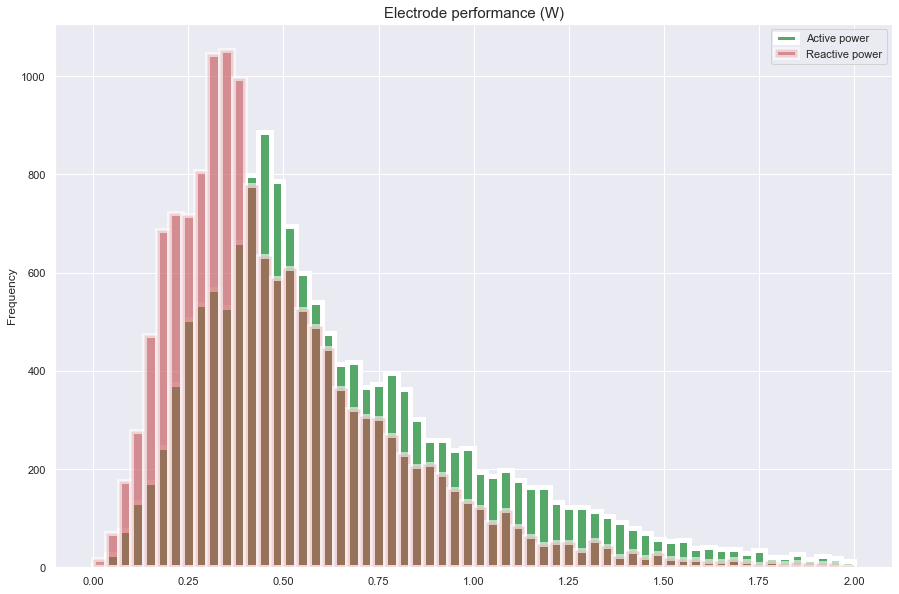

In [31]:
# distributions of active and reactive power
proj_hist()    

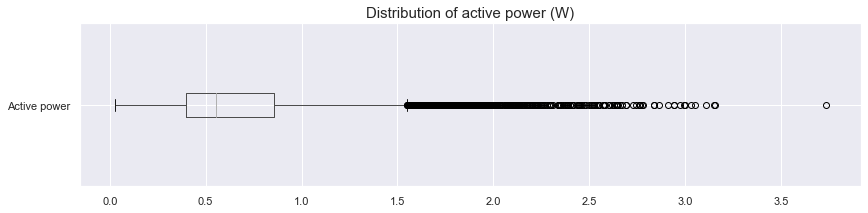

In [32]:
# boxplot of active power distribution
fig, ax = plt.subplots(figsize=(14, 3))
ax = arc_df[['Active power']].boxplot(vert=False, ax=ax)
ax.set_title('Distribution of active power (W)', fontsize=15);

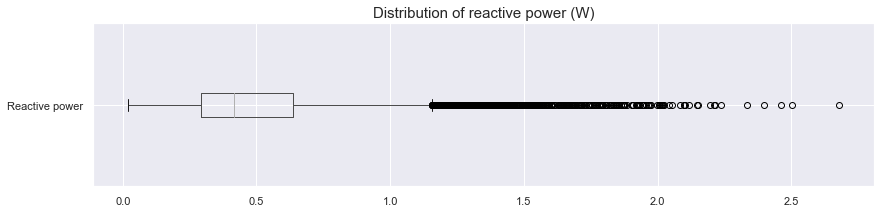

In [33]:
# boxplot of reactive power distribution
fig, ax = plt.subplots(figsize=(14, 3))
arc_t_df = arc_df[arc_df['Reactive power'] > 0]
ax = arc_t_df[['Reactive power']].boxplot(vert=False, ax=ax)
ax.set_title('Distribution of reactive power (W)', fontsize=15);

#### Bulk doping materials

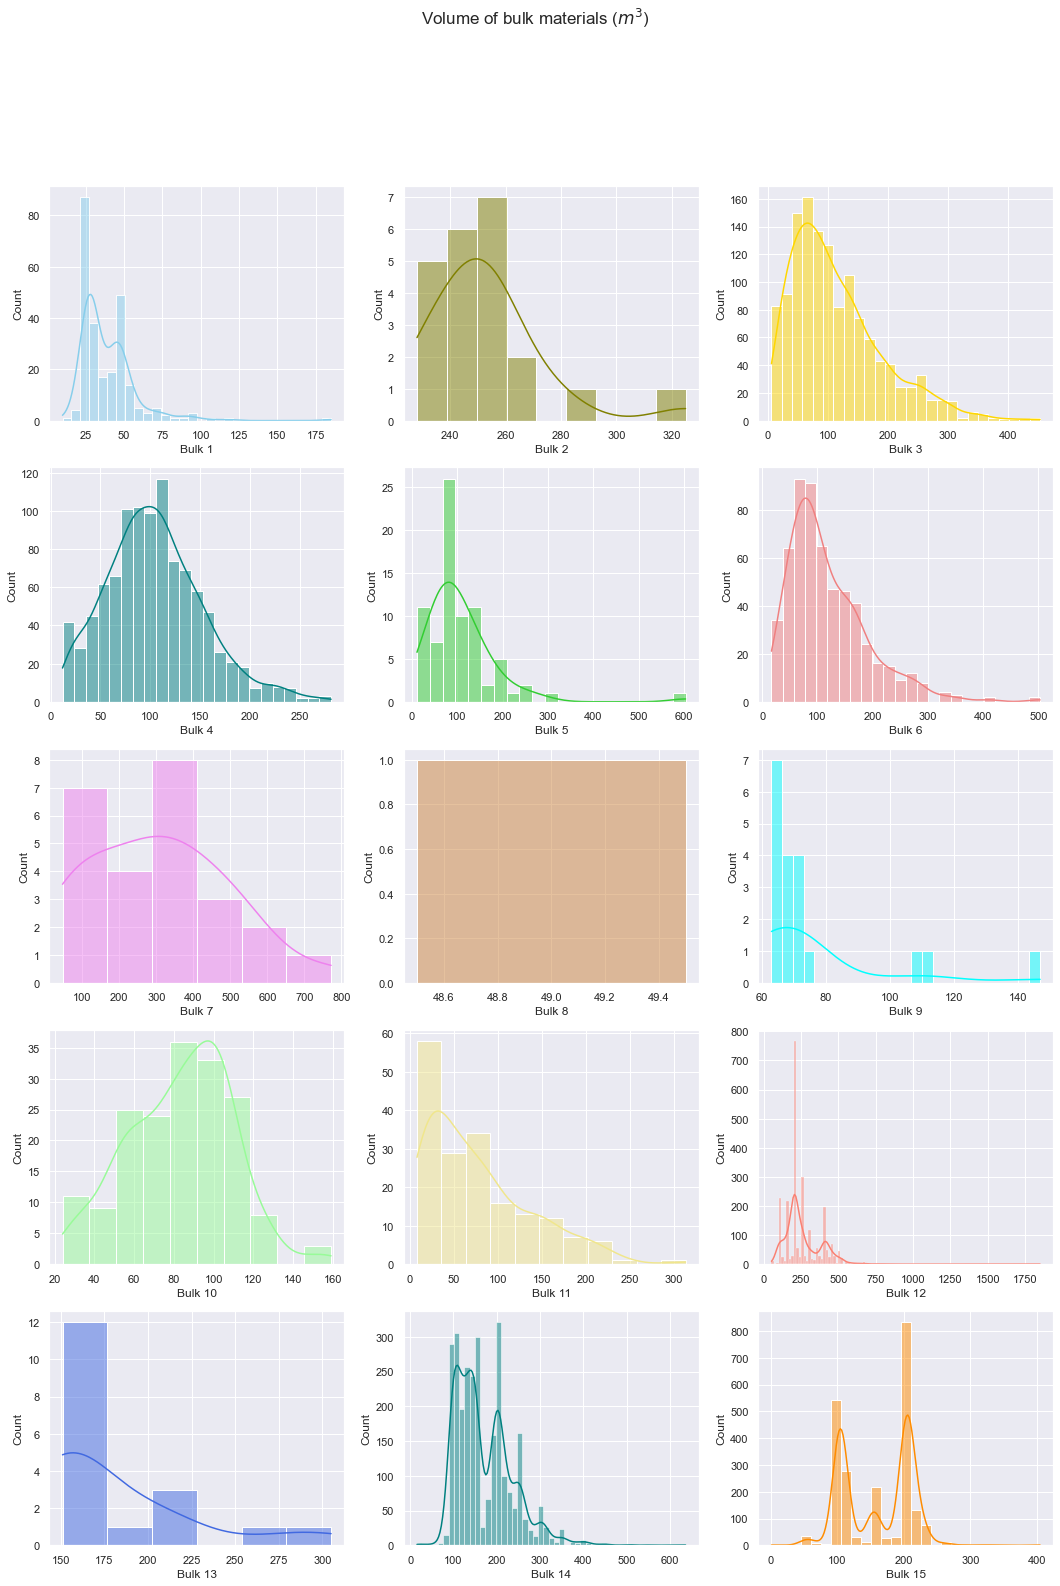

In [34]:
# histograms of bulk doping materials
mult_hist(bulk_df, row=5, col=3, param='bulk', x_axis=bulk, color=color, figsize=(18, 25))

#### Purging gas

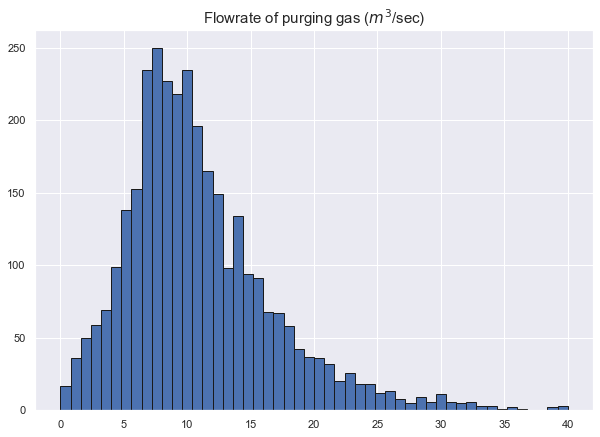

In [35]:
# histogram of purging gas distribution
gas_df.hist('Gas', bins=50, range=(0, 40), ec='k', figsize=(10, 7))
plt.title('Flowrate of purging gas ($m^3$/sec)', fontsize=15);

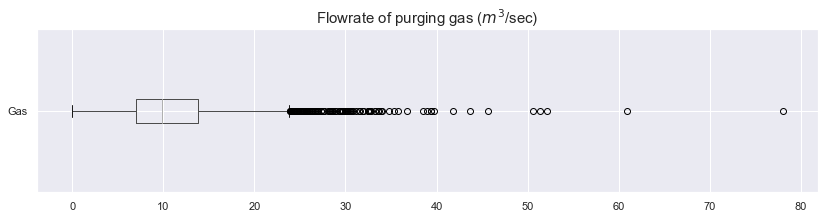

In [36]:
# boxplot of purging gas distribution
fig, ax = plt.subplots(figsize=(14, 3))
ax = gas_df[['Gas']].boxplot(vert=False, ax=ax)
ax.set_title('Flowrate of purging gas ($m^3$/sec)', fontsize=15);

#### Temperature measured

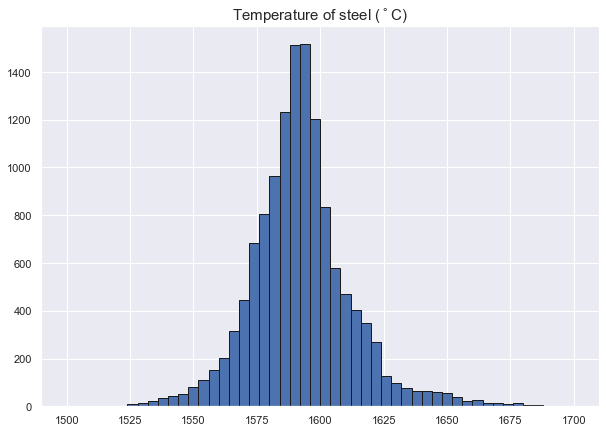

In [37]:
# histogram of temperature distribution
temp_df.hist('Temperature', bins=50, range=(1500, 1700), ec='k', figsize=(10, 7))
plt.title('Temperature of steel ($^\circ$C)', fontsize=15);

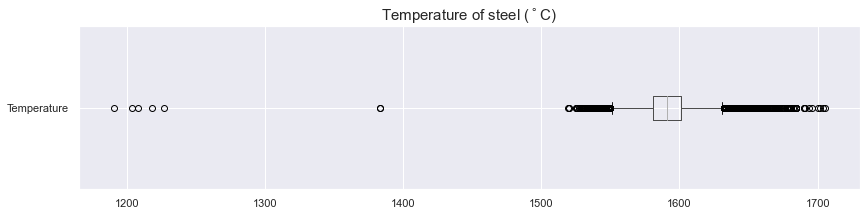

In [38]:
# boxplot of temperature distribution
fig, ax = plt.subplots(figsize=(14, 3))
ax = temp_df[['Temperature']].boxplot(vert=False, ax=ax)
ax.set_title('Temperature of steel ($^\circ$C)', fontsize=15);

#### Wire doping materials

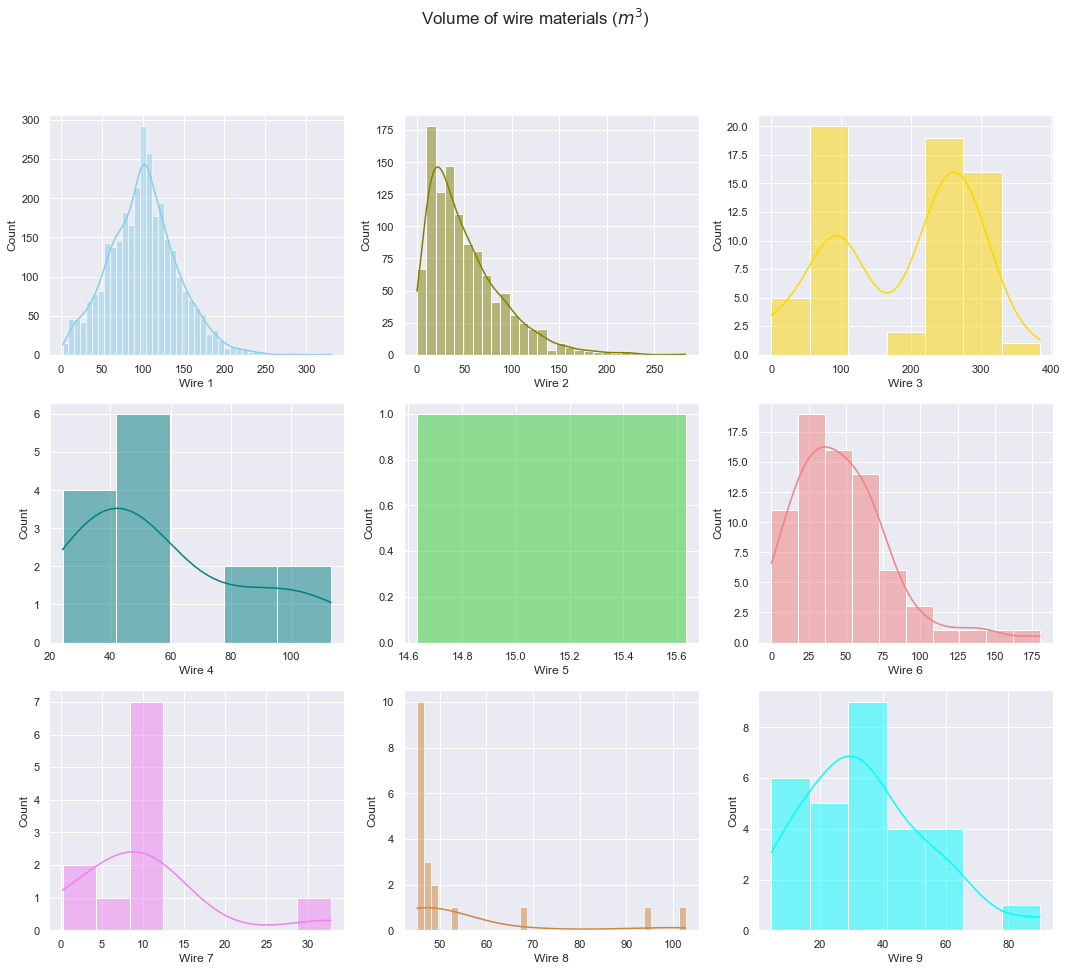

In [39]:
# histograms of wire doping materials
mult_hist(wire_df, row=3, col=3, param='wire', x_axis=wire, color=color, figsize=(18, 15))

Статистический анализ показал, что распределение целевого признака - температуры является нормальным, медианная температура примерно равна 1590 С. Нижняя граница boxplot равна 1525 С, верхняя 1675 С — это 1.5 межквартильного размаха, добавленного к 3-му квартилю. Это ориентировочная граница нормального размаха. Всё, что лежит за ней, считается выбросом.

Основной ключевой параметр при предсказании температуры стали это характеристики электродов. Их значения также распределены нормально, хотя смещены влево к нулевому показателю мощности. Медианное значение активной мощности около 0.6 Вт, реактивной около 0.35 Вт, при этом их максимальная разность может достигать 1 Вт, что видно при пересечении распределений.

Остальные параметры для построения модели машинного обучения включают лигирующие насыпные и проволочные материалы. Наибольший объем насыпных материалов у Bulk 2 и Bulk 7, в диапазоне 250..300 м3. При этом они в среднем использовались по 5 раз для всех партий. Напротив, наиболее часто применяемые насыпные материалы - Bulk 14 и Bulk 15, подавались 250 и 400 раз соответственно.

Наибольший по объему проволочный материал - Wire 3 со значением около 250 м3. Однако больше всего для всех партий применялся материал Wire 1 - 250 раз с медианным объемом 100 м3.

Все вышеперечисленные параметры оборудования и материалов также могут быть использованы для дальнейшей оптимизации затрат на пуско-наладку, улучшения тех. процесса обработки стали и закупки материалов при достижении целевого показателя температуры.

## Этап 2. Уточнение задачи

1. Длительность времени между первым и последним замером температуры.

    В `data_temp` нужно использовать группировку `df.groupby(by=key)` и с помощью аггрегирующих функций (`min` и `max`) по времени замера найти разность для каждого номера партии (key)?  


2. Суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродов.
    
    В `data_arc` сначала для каждой строки найти разность между атрибутами `Конец нагрева дугой` и `Начало нагрева дугой`, а потом с помощью группировки `df.groupby(by=key)` и аггрегирующей функции `sum` найти сумму значений для каждого номера партии (key)? 


3. Количество запусков нагрева электродами.
    
    В `data_arc` нужно использовать группировку `df.groupby(by=key)` и с помощью аггрегирующей функции `count` найти количество значений для каждого номера партии (key)? 


4. Среднее соотношение потребления активной и реактивной мощности.

    В `data_arc` нужно использовать группировку `df.groupby(by=key)` и с помощью аггрегирующей функции `avg` найти средние значения в `Активная мощность` и `Реактивная мощность` для каждого номера партии (key)? 


5. Предобработка данных и разработка модели

    Так понимаю что для обучения модели лучше все данные объединить в одну таблицу (+ новые столбцы из `data_temp` и `data_arc` после аггрегирующий функций примененных ранее) по значению `key`? 

    Потом построить матрицу корреляции и выполнить feature importance чтобы выявить какие фичи в итоге использовать?


## Этап 3. Предобработка данных и разработка модели

### Pre-processing

#### Длительность времени между первым и последним замером температуры

In [40]:
# check for NaN values in 'temp_df'
temp_na = temp_df[temp_df.isna().any(axis=1)]
temp_na.isna().any()

key                    False
Date of measurement    False
Temperature             True
dtype: bool

In [41]:
# # replace NaN in column 'Temperature' with the mean
# temp_df['Temperature'].fillna(value=temp_df['Temperature'].mean(), inplace=True)
# temp_df.isna().any()

In [42]:
# convert 'Date of measurement' from object to datetime type
temp_df['Date of measurement'] = pd.to_datetime(
    temp_df['Date of measurement'], format='%Y-%m-%d %H:%M:%S.%f'
)

In [43]:
# apply aggregation to find difference between first and last measurement
temp_duration = temp_df.groupby('key')['Date of measurement']\
    .agg(['first', 'last'])\
    .diff(axis=1)\
    .drop(['first'], axis=1)\
    .rename(columns={'last': 'Measurment duration (days)'})

# convert days to seconds
temp_duration['Measurment duration (sec)'] = temp_duration['Measurment duration (days)']\
    .dt.total_seconds()\
    .astype(int)

# drop 'Duration (days)' column
temp_duration = temp_duration.drop(['Measurment duration (days)'], axis=1)   

In [44]:
# print out parameters of measurment duration
display(temp_duration.head())
print('Number of rows:', len(temp_duration))   
print('Average value :', round(temp_duration['Measurment duration (sec)'].mean(), 2))
print('Minimum value :', temp_duration['Measurment duration (sec)'].min())
print('Maximum value :', temp_duration['Measurment duration (sec)'].max())
print('Median value  :', int(temp_duration['Measurment duration (sec)'].median()))
print('25%-quantile  :', int(temp_duration['Measurment duration (sec)'].quantile(0.25)))
print('75%-quantile  :', int(temp_duration['Measurment duration (sec)'].quantile(0.75)))

,Measurment duration (sec)
key,
1,861
2,1305
3,1300
4,388
5,762


Number of rows: 3216
Average value : 1839.86
Minimum value : 0
Maximum value : 23537
Median value  : 1581
25%-quantile  : 1177
75%-quantile  : 2235


#### Суммарное время нагрева электродами (сумма значений по всем промежуткам между запусками нагрева электродов)

In [45]:
# check for NaN values in 'temp_df'
arc_na = arc_df[arc_df.isna().any(axis=1)]
arc_na.isna().any()

key                     False
Start of arc heating    False
End of arc heating      False
Active power            False
Reactive power          False
dtype: bool

In [46]:
# convert 'Start of arc heating' from object to datetime type
arc_df['Start of arc heating'] = pd.to_datetime(
    arc_df['Start of arc heating'], format='%Y-%m-%d %H:%M:%S.%f'
)

# convert 'End of arc heating' from object to datetime type
arc_df['End of arc heating'] = pd.to_datetime(
    arc_df['End of arc heating'], format='%Y-%m-%d %H:%M:%S.%f'
)

In [47]:
# find difference between 'Start of arc heating' and 'End of arc heating'
arc_time = arc_df[['key', 'Start of arc heating', 'End of arc heating']]
arc_time['Difference'] = (arc_time['End of arc heating'] - arc_time['Start of arc heating'])\
    .dt.total_seconds()\
    .astype(int)

# apply aggregation to find sum of heating time
arc_time = arc_time.groupby('key')['Difference']\
    .agg(['sum'])\
    .rename(columns={'sum': 'Total heating time (sec)'})        

In [48]:
# print out parameters of total heating time
display(arc_time.head())
print('Number of rows:', len(arc_time)) 
print('Average value :', round(arc_time['Total heating time (sec)'].mean(), 2))
print('Minimum value :', arc_time['Total heating time (sec)'].min())
print('Maximum value :', arc_time['Total heating time (sec)'].max())
print('Median value  :', int(arc_time['Total heating time (sec)'].median()))
print('25%-quantile  :', int(arc_time['Total heating time (sec)'].quantile(0.25)))
print('75%-quantile  :', int(arc_time['Total heating time (sec)'].quantile(0.75)))

,Total heating time (sec)
key,
1,1098
2,811
3,655
4,741
5,869


Number of rows: 3214
Average value : 794.58
Minimum value : 57
Maximum value : 4189
Median value  : 770
25%-quantile  : 571
75%-quantile  : 983


#### Количество запусков нагрева электродами

In [49]:
# count heating cycles based on 'End of arc heating'
arc_count = arc_df.groupby('key')['End of arc heating']\
    .agg(['count'])\
    .rename(columns={'count': 'Heating cycle count (times)'})

In [50]:
# print out parameters of heating cycle count
display(arc_count.head()) 
print('Number of rows:', len(arc_count))    
print('Average value :', round(arc_count['Heating cycle count (times)'].mean(), 2))
print('Minimum value :', arc_count['Heating cycle count (times)'].min())
print('Maximum value :', arc_count['Heating cycle count (times)'].max())
print('Median value  :', int(arc_count['Heating cycle count (times)'].median()))
print('25%-quantile  :', int(arc_count['Heating cycle count (times)'].quantile(0.25)))
print('75%-quantile  :', int(arc_count['Heating cycle count (times)'].quantile(0.75)))

,Heating cycle count (times)
key,
1,5
2,4
3,5
4,4
5,4


Number of rows: 3214
Average value : 4.63
Minimum value : 1
Maximum value : 16
Median value  : 4
25%-quantile  : 4
75%-quantile  : 6


#### Среднее соотношение потребления активной и реактивной мощности

In [51]:
# find difference between 'Active power' and 'Reactive power'
arc_power = arc_df[['key', 'Active power', 'Reactive power']]
arc_power['Difference'] = (arc_power['Active power'] - arc_power['Reactive power'])

# apply aggregation to find average power difference
arc_power = arc_power.groupby('key')['Difference']\
    .agg(['mean'])\
    .rename(columns={'mean': 'Avg power difference (W)'})  

In [52]:
# print out parameters of avg power difference
display(arc_power.head())
print('Number of rows:', len(arc_power)) 
print('Average value :', round(arc_power['Avg power difference (W)'].mean(), 2))
print('Minimum value :', round(arc_power['Avg power difference (W)'].min(), 2))
print('Maximum value :', round(arc_power['Avg power difference (W)'].max(), 2))
print('Median value  :', round(arc_power['Avg power difference (W)'].median(), 2))
print('25%-quantile  :', round(arc_power['Avg power difference (W)'].quantile(0.25), 2))
print('75%-quantile  :', round(arc_power['Avg power difference (W)'].quantile(0.75), 2))

,Avg power difference (W)
key,
1,0.34
2,0.26
3,0.19
4,0.29
5,0.27


Number of rows: 3214
Average value : 0.23
Minimum value : -0.38
Maximum value : 179.11
Median value  : 0.16
25%-quantile  : 0.12
75%-quantile  : 0.22


#### Формирование финального датасета с параметрами для обучения модели

In [53]:
# set 'key' as index
bulk_volume = bulk_df.set_index('key')
bulk_time = bulk_time_df.set_index('key')
gas_flowrate = gas_df.set_index('key')
wire_volume = wire_df.set_index('key')
wire_time = wire_time_df.set_index('key')

In [54]:
# rename column 'Gas'
gas_flowrate = gas_flowrate.rename(columns={'Gas': 'Gas flowrate (m3/sec)'})

In [55]:
# converter of datetime to month, week and day
def date_converter():

    bulk_month = bulk_time.copy()
    bulk_week = bulk_time.copy()
    bulk_day = bulk_time.copy()
    
    wire_month = wire_time.copy()
    wire_week = wire_time.copy()
    wire_day = wire_time.copy()

    for i in bulk_time.columns:
        bulk_month[i] = pd.to_datetime(bulk_time[i]).dt.month
        bulk_week[i] = pd.to_datetime(bulk_time[i]).dt.week
        bulk_day[i] = pd.to_datetime(bulk_time[i]).dt.weekday

    for j in wire_time.columns:
        wire_month[j] = pd.to_datetime(wire_time[j]).dt.month
        wire_week[j] = pd.to_datetime(wire_time[j]).dt.week
        wire_day[j] = pd.to_datetime(wire_time[j]).dt.weekday

    return bulk_month, bulk_week, bulk_day, wire_month, wire_week, wire_day        

In [56]:
# convert datetime to month, week and day
bulk_month, bulk_week, bulk_day, wire_month, wire_week, wire_day = date_converter()

In [57]:
# define list of datasets
dfs = [arc_power, 
       arc_count, 
       arc_time, 
       bulk_volume, 
       bulk_month,
       bulk_week,
       bulk_day, 
       gas_flowrate, 
       wire_volume, 
       wire_month,
       wire_week,
       wire_day]

# merge all datasets into one except 'temp_duration'
df = reduce(lambda left, right: pd.merge(left, right, on=['key'], how='inner'), dfs)

# merge 'df' with 'temp_duration' (left)
final_df = pd.merge(temp_duration, df, on=['key'], how='left').fillna(0)

In [58]:
# display final dataset with features
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(final_df.head())
    
print('Size of dataset:', final_df.shape)

,Measurment duration (sec),Avg power difference (W),Heating cycle count (times),Total heating time (sec),Bulk 1_x,Bulk 2_x,Bulk 3_x,Bulk 4_x,Bulk 5_x,Bulk 6_x,Bulk 7_x,Bulk 8_x,Bulk 9_x,Bulk 10_x,Bulk 11_x,Bulk 12_x,Bulk 13_x,Bulk 14_x,Bulk 15_x,Bulk 1_y,Bulk 2_y,Bulk 3_y,Bulk 4_y,Bulk 5_y,Bulk 6_y,Bulk 7_y,Bulk 8_y,Bulk 9_y,Bulk 10_y,Bulk 11_y,Bulk 12_y,Bulk 13_y,Bulk 14_y,Bulk 15_y,Bulk 1_x,Bulk 2_x,Bulk 3_x,Bulk 4_x,Bulk 5_x,Bulk 6_x,Bulk 7_x,Bulk 8_x,Bulk 9_x,Bulk 10_x,Bulk 11_x,Bulk 12_x,Bulk 13_x,Bulk 14_x,Bulk 15_x,Bulk 1_y,Bulk 2_y,Bulk 3_y,Bulk 4_y,Bulk 5_y,Bulk 6_y,Bulk 7_y,Bulk 8_y,Bulk 9_y,Bulk 10_y,Bulk 11_y,Bulk 12_y,Bulk 13_y,Bulk 14_y,Bulk 15_y,Gas flowrate (m3/sec),Wire 1_x,Wire 2_x,Wire 3_x,Wire 4_x,Wire 5_x,Wire 6_x,Wire 7_x,Wire 8_x,Wire 9_x,Wire 1_y,Wire 2_y,Wire 3_y,Wire 4_y,Wire 5_y,Wire 6_y,Wire 7_y,Wire 8_y,Wire 9_y,Wire 1_x,Wire 2_x,Wire 3_x,Wire 4_x,Wire 5_x,Wire 6_x,Wire 7_x,Wire 8_x,Wire 9_x,Wire 1_y,Wire 2_y,Wire 3_y,Wire 4_y,Wire 5_y,Wire 6_y,Wire 7_y,Wire 8_y,Wire 9_y
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,861,0.34,5.0,1098.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,5.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,18.0,18.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,4.0,29.75,60.06,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1305,0.26,4.0,811.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,5.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,18.0,18.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,4.0,12.56,96.05,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1300,0.19,5.0,655.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,5.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,18.0,18.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,4.0,28.55,91.16,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,388,0.29,4.0,741.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,5.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,18.0,18.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,4.0,18.84,89.06,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,762,0.27,4.0,869.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,5.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,18.0,18.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,4.0,5.41,89.24,9.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Size of dataset: (3216, 101)


In [64]:
# function for finding duplicated columns
def duplicated_columns(data):
 
    dupl_cols = set()
 
    for x in range(data.shape[1]):
 
        # take column at xth index
        first_col = data.iloc[:, x]
 
        for y in range(x + 1, data.shape[1]):
 
            # take column at yth index
            second_col = data.iloc[:, y]
 
            # check whether two columns at x & y index are equal or not
            if first_col.equals(second_col):
                dupl_cols.add(data.columns.values[y])
 
    return list(dupl_cols)

In [65]:
# find dublicated columns
dupl_cols = duplicated_columns(final_df)
dupl_cols

['Wire 8_y', 'Wire 8_x']

In [80]:
# drop duplicated columns
final_df = final_df.drop(columns=dupl_cols, axis=1)

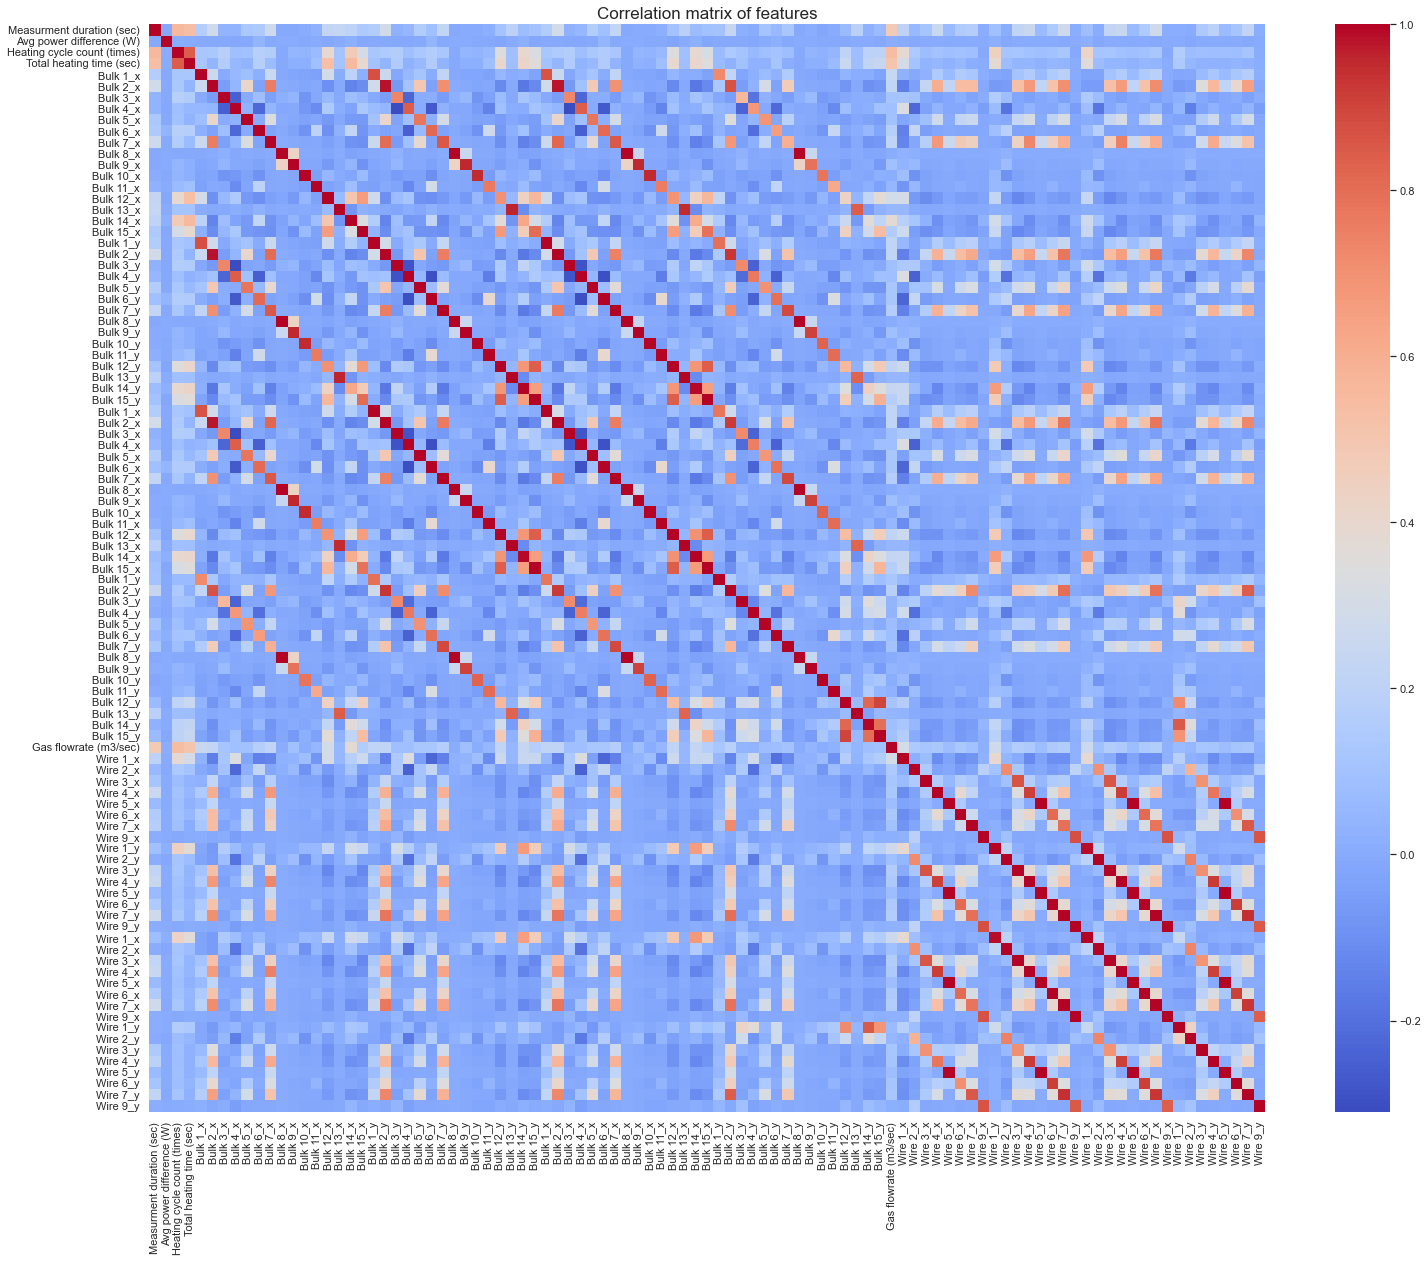

In [90]:
# heatmap of correlation matrix
fig, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(final_df.corr(), cmap='coolwarm', ax=ax)\
   .set_title('Correlation matrix of features', fontsize=17)
plt.show()

In [107]:
# get diagonal and lower triangular pairs of correlation matrix 
def redundant_pairs(data):
    pairs_to_drop = set()
    cols = data.columns
    
    for i in range(0, data.shape[1]):
        for j in range(0, i + 1):
            pairs_to_drop.add((cols[i], cols[j]))
    
    return pairs_to_drop

In [108]:
# function for printing top correlated pairs
def top_correlations(data, n=5):
    au_corr = data.corr(method='pearson').abs().unstack()
    labels_to_drop = redundant_pairs(data)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    
    return au_corr[0:n]

In [158]:
# print out top-5 correlations
print('Top Absolute Correlations')
print(top_correlations(final_df, 5))

Top Absolute Correlations
Bulk 14_y                    Wire 1_y                    0.85
Bulk 2_y                     Wire 7_y                    0.84
Heating cycle count (times)  Total heating time (sec)    0.84
Bulk 2_y                     Wire 7_y                    0.80
                             Wire 7_x                    0.79
dtype: float64


### ML models

#### Features and target

In [97]:
# create features
X = final_df.reset_index().drop(['key'], axis=1)

In [98]:
# create target by applying aggregation to find the last temperature measured
y = temp_df.groupby('key')['Temperature']\
    .agg(['last'])\
    .rename(columns={'last': 'Temperature of steel (C)'})\
    .reset_index()\
    .drop(['key'], axis=1)    

In [99]:
# display target
display(y.head())
print('Number of rows:', len(y)) 

,Temperature of steel (C)
0,1613.0
1,1602.0
2,1599.0
3,1625.0
4,1602.0


Number of rows: 3216


In [100]:
# split train and test data by 75/25 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=141122, shuffle=True
)

#### Transformation pipeline

In [123]:
# Fit the models, transform and return prediction
class TypeSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, dtype):
        self.dtype = dtype
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

In [197]:
# transformer pipline for linear models
transformer_linear = Pipeline([
    ('features', FeatureUnion(n_jobs=1, transformer_list=[
        
        ('boolean', Pipeline([('selector', TypeSelector('bool')),])),  # booleans close
        
        ('numericals', Pipeline([
            ('selector', TypeSelector(np.number)),
            ('imputer', SimpleImputer()),
            ('scaler', StandardScaler()),
            
        ])),  # numericals close
    ])),  # features close
])  # pipeline close

In [198]:
# transformer pipline for non-linear models
transformer_nonlinear = Pipeline([
    ('features', FeatureUnion(n_jobs=1, transformer_list=[
        
        ('boolean', Pipeline([('selector', TypeSelector('bool')),])),  # booleans close
        
        ('numericals', Pipeline([
            ('selector', TypeSelector(np.number)),
            ('imputer', SimpleImputer())
            
        ])),  # numericals close
    ])),  # features close
])  # pipeline close

In [225]:
# estimator pipeline
estimators=[
    ('Bagging Regressor', BaggingRegressor(LGBMRegressor(objective='mae'), random_state=141122)),
    ('Random Forest', RandomForestRegressor(criterion='mae', random_state=141122)),
    ('LGBM Regressor', LGBMRegressor(objective='mae', random_state=141122)),
    ('Gradient Boosting', GradientBoostingRegressor(criterion='mae', random_state=141122)),
    ('XGB Regressor', XGBRegressor(eval_metric='mae', random_state=141122)),
    ('Theil-Sen Regression', TheilSenRegressor(random_state=141122)),
    ('Lasso Regression', Lasso(random_state=141122)),
    ('Support Vector Regression', SVR())
]

In [226]:
# models pipeline
def pipe_builder():
    pipes = {}
    for model in estimators:
        for name in model:
            
            if name in ['Lasso Regression', 'Theil-Sen Regression']:
                pipe = Pipeline(steps=[('data_prep', transformer_linear), model])
                pipe.fit(X_train, y_train)
                pipes[pipe.steps[1][0]] = pipe

            else:
                pipe = Pipeline(steps=[('data_prep', transformer_nonlinear), model])
                pipe.fit(X_train, y_train)
                pipes[pipe.steps[1][0]] = pipe

    return pipes                     

In [227]:
# build pipes
pipes = pipe_builder()

#### Feature importance

In [ ]:
# function for calculating most important features
def feature_importances(data, models):
    
    tree_based = models
    for name in pipes.keys(): 
        if name in tree_based:
            feat_impt = pipes[name].named_steps[name].feature_importances_
            graph_data = pd.DataFrame()

            graph_data['feature'] = data.columns.values
            graph_data['importance'] = feat_impt
            graph_data_top = graph_data.nlargest(30, 'importance')

            plt.figure(figsize=(12, 10))
            g = sns.barplot(y='feature', x='importance', data=graph_data_top, orient='h')
            g.set_ylabel('Features', fontsize=12)
            g.set_xlabel('Relative Importance')
            g.set_title(name + ' feature importance', fontsize=15)
            g.tick_params(labelsize=12)
            print(' {} '.format(name).center(100, '*'))
            print(graph_data_top['feature'].tolist())
            print('')          

****************************************** Random Forest *******************************************
['Measurment duration (sec)', 'Gas flowrate (m3/sec)', 'Total heating time (sec)', 'Wire 1_x', 'Avg power difference (W)', 'Bulk 14_x', 'Wire 2_x', 'Heating cycle count (times)', 'Bulk 12_x', 'Bulk 15_x', 'Bulk 6_x', 'Wire 1_x', 'Bulk 14_x', 'Bulk 3_x', 'Bulk 3_x', 'Bulk 14_y', 'Bulk 15_x', 'Bulk 4_x', 'Wire 2_x', 'Bulk 12_x', 'Bulk 4_x', 'Bulk 6_x', 'Bulk 15_y', 'Bulk 12_y', 'Wire 1_y', 'Wire 4_x', 'Bulk 3_y', 'Wire 1_y', 'Bulk 3_y', 'Bulk 14_y']

**************************************** AdaBoost Regressor ****************************************
['Gas flowrate (m3/sec)', 'Total heating time (sec)', 'Measurment duration (sec)', 'Wire 1_x', 'Bulk 14_x', 'Wire 1_x', 'Avg power difference (W)', 'Heating cycle count (times)', 'Bulk 6_x', 'Bulk 12_x', 'Wire 4_x', 'Bulk 7_y', 'Bulk 7_x', 'Bulk 15_x', 'Wire 3_x', 'Bulk 1_y', 'Bulk 7_y', 'Bulk 4_x', 'Bulk 3_x', 'Bulk 1_x', 'Bulk 2_x', 'Bulk 5_

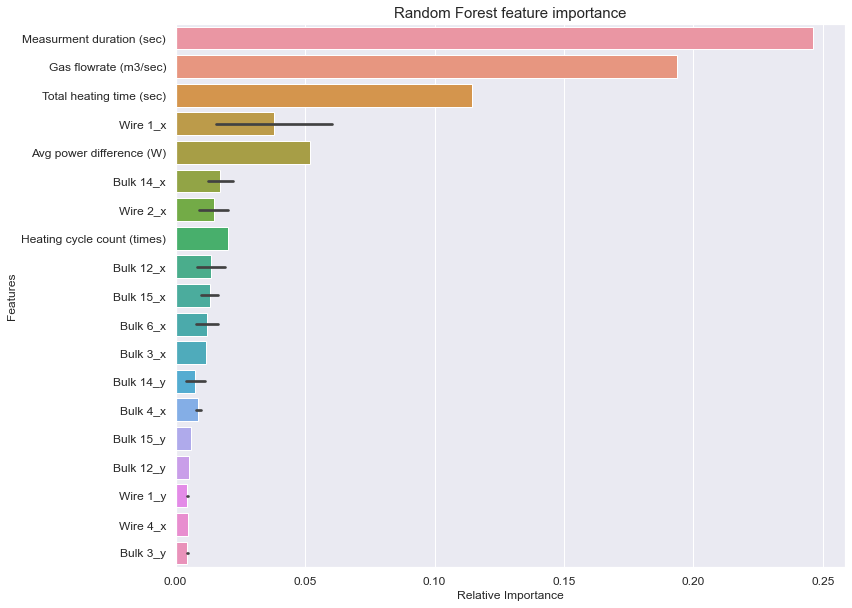

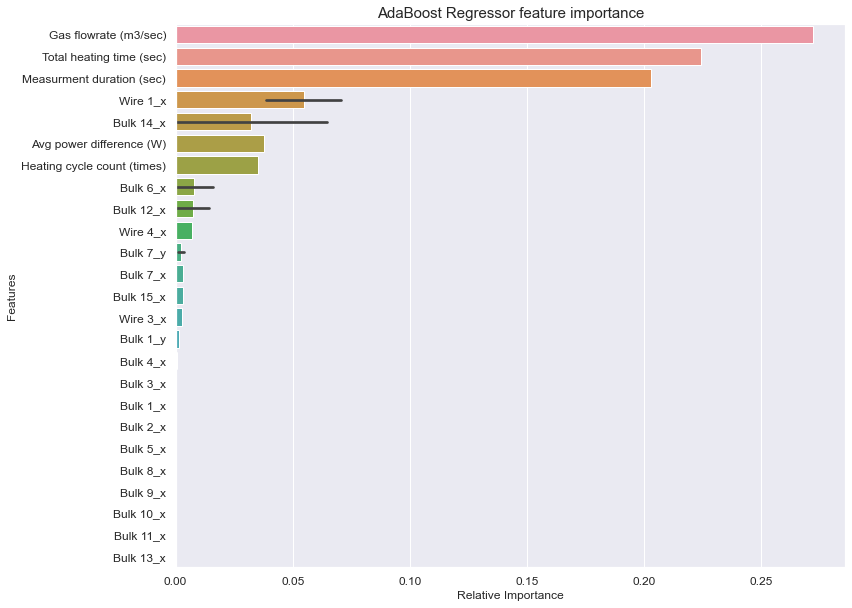

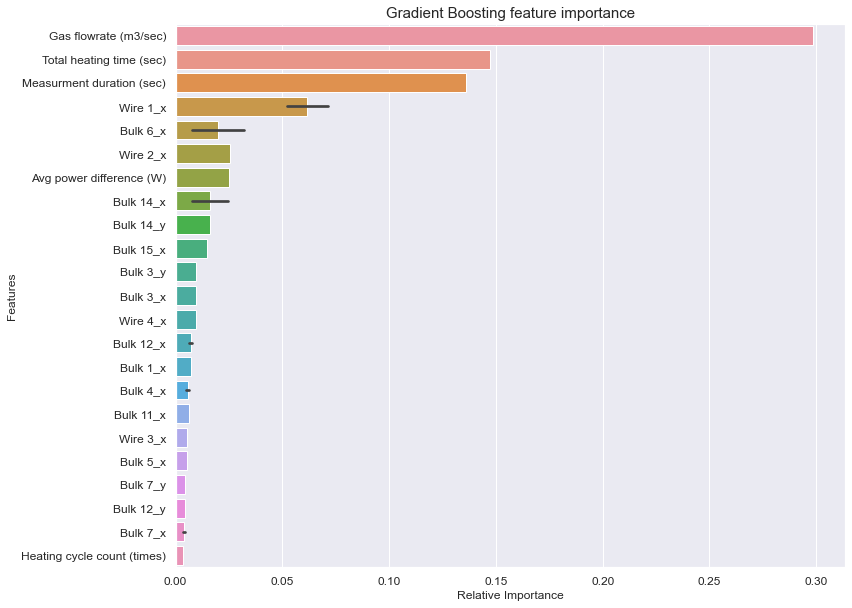

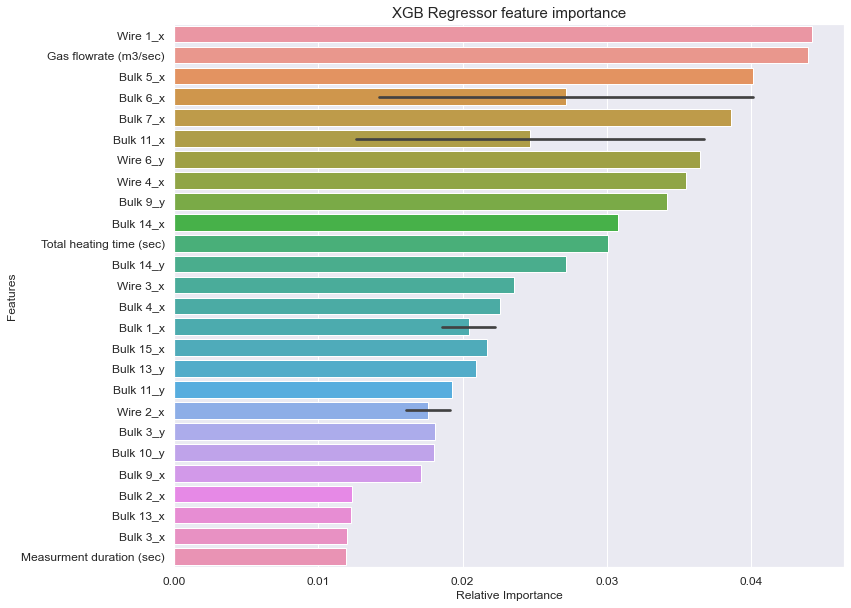

In [ ]:
# peint out most important features
tree_based = ['Gradient Boosting', 'Random Forest', 'XGB Regressor', 'LGBM Regressor']
feature_importances(data=X_train, models=tree_based) 

In [ ]:
# most important features
rf_list = ['Measurment duration (sec)', 'Gas flowrate (m3/sec)', 'Total heating time (sec)', 'Wire 1_x', 
           'Avg power difference (W)', 'Bulk 14_x', 'Wire 2_x', 'Heating cycle count (times)', 'Bulk 12_x', 
           'Bulk 15_x', 'Bulk 6_x', 'Wire 1_x', 'Bulk 14_x', 'Bulk 3_x', 'Bulk 3_x', 'Bulk 14_y', 'Bulk 15_x', 
           'Bulk 4_x', 'Wire 2_x', 'Bulk 12_x', 'Bulk 4_x', 'Bulk 6_x', 'Bulk 15_y', 'Bulk 12_y', 'Wire 1_y', 
           'Wire 4_x', 'Bulk 3_y', 'Wire 1_y', 'Bulk 3_y', 'Bulk 14_y']

gb_list = ['Gas flowrate (m3/sec)', 'Total heating time (sec)', 'Measurment duration (sec)', 'Wire 1_x', 
           'Wire 1_x', 'Bulk 6_x', 'Wire 2_x', 'Avg power difference (W)', 'Bulk 14_x', 'Bulk 14_y', 'Bulk 15_x', 
           'Bulk 3_y', 'Bulk 3_x', 'Wire 4_x', 'Bulk 14_x', 'Bulk 12_x', 'Bulk 6_x', 'Bulk 1_x', 'Bulk 1_x', 
           'Bulk 4_x', 'Bulk 12_x', 'Bulk 11_x', 'Wire 3_x', 'Bulk 5_x', 'Bulk 4_x', 'Bulk 7_y', 'Bulk 12_y', 
           'Bulk 7_x', 'Heating cycle count (times)', 'Bulk 7_x']         

In [ ]:
# function for finding intersection between two sets
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [ ]:
# final most important features
final_features = intersection(rf_list, gb_list)
final_features

['Bulk 15_x',
 'Avg power difference (W)',
 'Bulk 14_y',
 'Total heating time (sec)',
 'Measurment duration (sec)',
 'Bulk 4_x',
 'Bulk 3_y',
 'Bulk 12_x',
 'Bulk 3_x',
 'Bulk 14_x',
 'Wire 1_x',
 'Wire 4_x',
 'Wire 2_x',
 'Heating cycle count (times)',
 'Bulk 6_x',
 'Bulk 12_y',
 'Gas flowrate (m3/sec)']

In [ ]:
# final features based on feature importance scores
X_train_final = X_train[final_features]
X_test_final = X_test[final_features]

In [ ]:
# print out top-5 correlations
print('Top Absolute Correlations of train data')
print(top_correlations(X_train_final, 5))
print()
print('Top Absolute Correlations of test data')
print(top_correlations(X_test_final, 5))

Top Absolute Correlations of train data
Bulk 3_y                  Bulk 3_x                       1.00
Bulk 12_x                 Bulk 12_y                      1.00
Bulk 14_y                 Bulk 14_x                      0.99
Total heating time (sec)  Heating cycle count (times)    0.84
Bulk 15_x                 Bulk 12_x                      0.84
dtype: float64

Top Absolute Correlations of test data
Bulk 3_y   Bulk 3_x     1.00
Bulk 12_x  Bulk 12_y    1.00
Bulk 14_y  Bulk 14_x    0.99
Bulk 15_x  Bulk 12_x    0.86
           Bulk 12_y    0.85
dtype: float64


In [ ]:
# drop highly correlated columns
X_train_final = X_train_final.drop(columns=['Bulk 3_x', 'Bulk 12_y', 'Bulk 14_x'], axis=1)
X_test_final = X_test_final.drop(columns=['Bulk 3_x', 'Bulk 12_y', 'Bulk 14_x'], axis=1)

In [174]:
# shape of features
X_train_final.shape

(2412, 23)

#### Initial model scoring

In [221]:
# initialize metrics and estimator names
_metrics = {'mae': make_scorer(mean_absolute_error)}
estimator_names = [model[0] for model in estimators]

In [222]:
# function for plotting estimator results (boxplots)
def plot_estimators(estimators=estimator_names, n_splits=5, metrics=['mae'], row=2, col=4):
    
    color = [['skyblue', 'olive', 'gold', 'teal'], 
             ['limegreen', 'lightcoral', 'violet', 'khaki']] 

    metrics = {key: _metrics[key] for key in metrics}
    scorers = []
    labels = []
    for pipe_name in pipes.keys():
        if pipe_name in estimators:
            pipe = pipes[pipe_name]
            labels.append(pipe_name)
            kf = KFold(n_splits)
            model_score = cross_validate(pipe, X_train, y_train, scoring=metrics, cv=kf)
            scorers.append(model_score)
    
    score_lists = {}
    for metric in metrics:
        score_lists[metric] = [score['test_' + metric] for score in scorers]
    
    fig, axs = plt.subplots(row, col, figsize=(18, 5*row))
    fig.suptitle('Mean Absolute Error (MAE)', fontsize=15)
    for idx, (title, _list) in enumerate(score_lists.items()):
        
        if row == 2:

            for idx, column in zip(range(0, col), range(col)):
                plot = sns.boxplot(data=_list[idx], color=color[0][column], ax=axs[0, column])
                plot.set(title=estimators[idx])
                                      
            for idx, column in zip(range(col, col*row), range(col)):
                plot = sns.boxplot(data=_list[idx], color=color[1][column], ax=axs[1, column])
                plot.set(title=estimators[idx])

        if row == 1:

            for idx, column in zip(range(0, col), range(col)):
                plot = sns.boxplot(data=_list[idx], color=color[0][column], ax=axs[column])
                plot.set(title=estimators[idx])                    
    
    plt.show()   

In [223]:
# assign metrics
metrics = {'mae': make_scorer(mean_absolute_error)}     

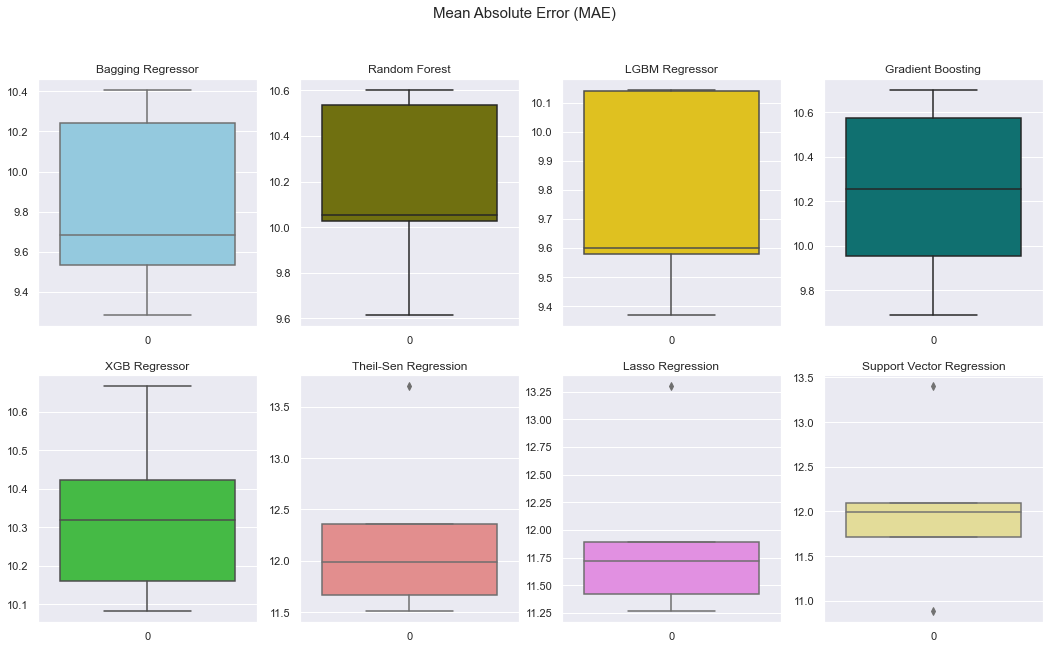

In [224]:
# plot MAE of all models
plot_estimators()    

#### Hyper-parameter tuning

In [180]:
# function for parameter tuning
def tune_param(model, param_grid, refit='mae', data=X_train_final, target=y_train, cv=5):
    
    param_grid = {model + '__' + key: param_grid[key] for key in param_grid.keys()}

    cv = GridSearchCV(pipes[model], param_grid, scoring=metrics, refit=refit, cv=cv)
    cv.fit(data, target)

    print('best score: ' + str(cv.best_score_))
    print('best params: ' + str(cv.best_params_))
    results = pd.DataFrame(cv.cv_results_)

##### Gradient Boosting

In [181]:
# Gradient Boosting model
pipes['Gradient Boosting'].named_steps['Gradient Boosting'].get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 141122,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [184]:
# show score for n_estimators 
param_grid = {'n_estimators': [10, 50, 100],
              'max_depth': [10, 50, 100],
              'max_leaf_nodes': [10, 50, 100],
              'learning_rate': [0.001, 0.01, 0.1]}

tune_param('Gradient Boosting', param_grid)

best score: 12.514809626600458
best params: {'Gradient Boosting__learning_rate': 0.001, 'Gradient Boosting__max_depth': 10, 'Gradient Boosting__max_leaf_nodes': 10, 'Gradient Boosting__n_estimators': 10, 'Gradient Boosting__subsample': 1}


In [75]:
# set the best n_estimators
pipes['Gradient Boosting'].set_params(**{'Gradient Boosting__n_estimators': 100})
pipes['Gradient Boosting'].set_params(**{'Gradient Boosting__max_depth': 40})
pipes['Gradient Boosting'].set_params(**{'Gradient Boosting__max_leaf_nodes': 70})
pipes['Gradient Boosting'].set_params(**{'Gradient Boosting__learning_rate': 0.02})
pipes['Gradient Boosting'].set_params(**{'Gradient Boosting__subsample': 1})

Pipeline(steps=[('data_prep',
                 Pipeline(steps=[('features',
                                  FeatureUnion(n_jobs=1,
                                               transformer_list=[('boolean',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype='bool'))])),
                                                                 ('numericals',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype=<class 'numpy.number'>)),
                                                                                  ('imputer',
                                                                                   SimpleImputer()),
                                                                                  

##### Random Forest

In [185]:
# Random Forest model
pipes['Random Forest'].named_steps['Random Forest'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 141122,
 'verbose': 0,
 'warm_start': False}

In [186]:
# show score for n_estimators
param_grid = {'n_estimators': [10, 50, 100, 200],
              'max_depth': [10, 50, 100, 150],
              'max_leaf_nodes': [10, 50, 100, 150]}

tune_param('Random Forest', param_grid)

best score: 10.99300290434541
best params: {'Random Forest__max_depth': 10, 'Random Forest__max_leaf_nodes': 10, 'Random Forest__n_estimators': 10}


In [86]:
# set the best n_estimators
pipes['Random Forest'].set_params(**{'Random Forest__n_estimators': 150})
pipes['Random Forest'].set_params(**{'Random Forest__max_depth': 20})
pipes['Random Forest'].set_params(**{'Random Forest__max_leaf_nodes': 100})

Pipeline(steps=[('data_prep',
                 Pipeline(steps=[('features',
                                  FeatureUnion(n_jobs=1,
                                               transformer_list=[('boolean',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype='bool'))])),
                                                                 ('numericals',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype=<class 'numpy.number'>)),
                                                                                  ('imputer',
                                                                                   SimpleImputer()),
                                                                                  

##### XGB Regressor

In [194]:
# XGB Regressor model
pipes['XGB Regressor'].named_steps['XGB Regressor'].get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 141122,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [195]:
# show score for n_estimators 
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [3, 5, 7, 9],
              'learning_rate': [0.001, 0.01, 0.1],
              'gamma':[0, 1, 5]}

tune_param('XGB Regressor', param_grid)

best score: 1515.991472580593
best params: {'XGB Regressor__gamma': 0, 'XGB Regressor__learning_rate': 0.001, 'XGB Regressor__max_depth': 3, 'XGB Regressor__n_estimators': 50}


##### Lasso Regression

In [193]:
# Lasso Regression model
pipes['Lasso Regression'].named_steps['Lasso Regression'].get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': 141122,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [92]:
# show score for tol
param_grid = {'tol':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
tune_param('Lasso Regression', param_grid)

best score: 8.120889731010582
best params: {'Lasso Regression__tol': 10}


In [93]:
# set the best tol
pipes['Lasso Regression'].set_params(**{'Lasso Regression__tol': 10})

Pipeline(steps=[('data_prep',
                 Pipeline(steps=[('features',
                                  FeatureUnion(n_jobs=1,
                                               transformer_list=[('boolean',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype='bool'))])),
                                                                 ('numericals',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype=<class 'numpy.number'>)),
                                                                                  ('imputer',
                                                                                   SimpleImputer()),
                                                                                  

##### Support Vector Regression

In [94]:
# Support Vector Regression model
pipes['Support Vector Regression'].named_steps['Support Vector Regression'].get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [95]:
# show score for C-param
param_grid = {'C':[0.01, 0.1, 1, 10, 100],
              'tol':[0.001, 0.01, 0.1]}
tune_param('Support Vector Regression', param_grid)

best score: 7.612699989414151
best params: {'Support Vector Regression__C': 0.01}


In [96]:
# set the best C-param
pipes['Support Vector Regression'].set_params(**{'Support Vector Regression__C': 0.01})
pipes['Support Vector Regression'].set_params(**{'Support Vector Regression__tol': 0.1})

Pipeline(steps=[('data_prep',
                 Pipeline(steps=[('features',
                                  FeatureUnion(n_jobs=1,
                                               transformer_list=[('boolean',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype='bool'))])),
                                                                 ('numericals',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype=<class 'numpy.number'>)),
                                                                                  ('imputer',
                                                                                   SimpleImputer()),
                                                                                  

#### Post-tuning scores

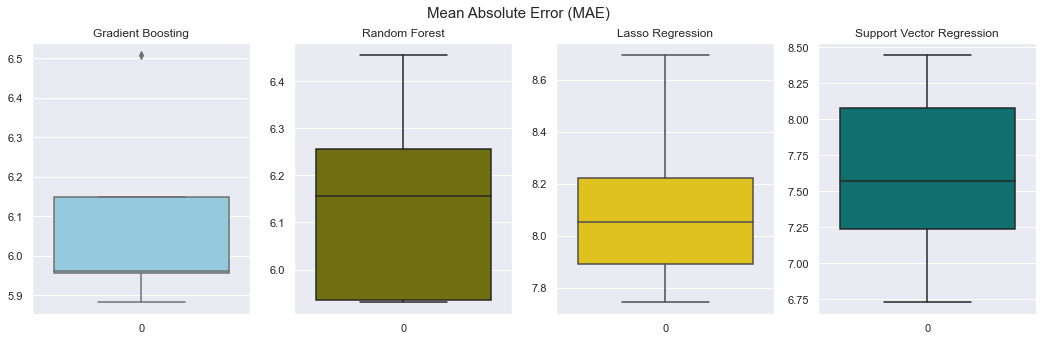

In [99]:
# # plot MAE of tuned models
plot_estimators(['Gradient Boosting', 'Random Forest', 'Lasso Regression', 'Support Vector Regression'], row=1)

#### Ensemble сreation and final testing

In [106]:
# function for calculating MAE
def print_predictions(target, predictions):
    print('mae: '+ str(mean_absolute_error(target, predictions)))

In [107]:
# print out MAE for each model
for name in pipes.keys():
    print(name)
    predictions = pipes[name].predict(X_test)
    print_predictions(y_test, predictions)
    print()

Linear Regression
mae: 832337312855.3173

Random Forest
mae: 5.944714776685505

Decision Tree
mae: 8.264416423189356

Gradient Boosting
mae: 7.771167603928536

Stochastic Gradient Descent
mae: 30597617075.455948

Theil-Sen Regression
mae: 205.84914149127172

Lasso Regression
mae: 10.974325958430876

Support Vector Regression
mae: 7.245490269958256



In [108]:
# Dummy Regressor model
dr = DummyRegressor(strategy='mean')

# fit the model for the 1st target
dr.fit(X_train_final, y_train)

# make predictions on testing data
pred_dummy = dr.predict(X_test_final)
dummy_score = mean_absolute_error(pred_dummy, y_test)
print('mae (dummy regressor):', round(dummy_score, 3))

mae (dummy regressor): 8.45


In [109]:
# list of final estimators
final_estimators = ['Random Forest', 'Decision Tree', 'Support Vector Regression', 'Lasso Regression']

In [110]:
# function for getting final score from differen combos
def final_combo(X_train, y_train, X_test, y_test):    
    
    combos = []
    for L in range(1, len(final_estimators) + 1):
        for subset in combinations(final_estimators, L):
            combos.append(list(subset))

    combo_names = []
    mae = []

    for combo in combos:
        estimators = [(name, clone(pipes[name].named_steps[name])) for name in combo] 
        vote = Pipeline(steps=[('data_prep', transformer), ('voter', VotingRegressor(estimators))])
        vote.fit(X_train, y_train)
        predictions = vote.predict(X_test)

        mae.append(mean_absolute_error(y_test, predictions))
        combo_names.append(str(list(combo)))
        
    score = pd.DataFrame()
    score['combo'] = combo_names
    score['mae'] = mae

    return score

In [111]:
# scores of combos
combo_df = final_combo(X_train_final, y_train, X_test_final, y_test)

In [112]:
# show top-10 models and their MAE scores
display(combo_df.head(10).sort_values(by='mae', ascending=True).reset_index(drop=True))

,combo,mae
0,['Random Forest'],5.96
1,"['Random Forest', 'Support Vector Regression']",6.59
2,"['Random Forest', 'Decision Tree']",6.75
3,"['Decision Tree', 'Support Vector Regression']",7.25
4,['Support Vector Regression'],7.71
5,['Decision Tree'],8.42
6,"['Random Forest', 'Lasso Regression']",9.26
7,"['Decision Tree', 'Lasso Regression']",9.98
8,"['Support Vector Regression', 'Lasso Regression']",10.14
9,['Lasso Regression'],13.05


## Этап 4. Составление отчета